In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

base_dir = "aifw2"
folders = ["dns", "flow", "http", "tls"]
dfs = []

for folder in folders:
    path_pattern = os.path.join(base_dir, folder, "*.parquet")
    files = glob.glob(path_pattern)
    
    for file in files:
        try:
            df = pd.read_parquet(file)
            df["source"] = folder
            dfs.append(df)
            print(f"✅ Зчитано: {file}")
        except Exception as e:
            print(f"❌ Помилка зчитування {file}: {e}")

if dfs:
    df = pd.concat(dfs, ignore_index=True)
else:
    print("⚠️ Не знайдено жодного parquet-файлу!")
    exit(1)

print(f"\n📊 Загальна кількість записів: {len(df)}")

output_csv = os.path.join(base_dir, "merged_logs.csv")
df.to_csv(output_csv, index=False)
print(f"💾 Дані збережено у: {output_csv}")


✅ Зчитано: aifw2/dns/2025101819.parquet
✅ Зчитано: aifw2/dns/2025101720.parquet
✅ Зчитано: aifw2/dns/2025101818.parquet
✅ Зчитано: aifw2/dns/2025101811.parquet
✅ Зчитано: aifw2/dns/2025101719.parquet
✅ Зчитано: aifw2/dns/2025101817.parquet
✅ Зчитано: aifw2/dns/2025101718.parquet
✅ Зчитано: aifw2/flow/2025101810.parquet
✅ Зчитано: aifw2/flow/2025101800.parquet
✅ Зчитано: aifw2/flow/2025101717.parquet
✅ Зчитано: aifw2/flow/2025101721.parquet
✅ Зчитано: aifw2/flow/2025101809.parquet
✅ Зчитано: aifw2/flow/2025101819.parquet
✅ Зчитано: aifw2/flow/2025101720.parquet
✅ Зчитано: aifw2/flow/2025101818.parquet
✅ Зчитано: aifw2/flow/2025101808.parquet
✅ Зчитано: aifw2/flow/2025101801.parquet
✅ Зчитано: aifw2/flow/2025101811.parquet
✅ Зчитано: aifw2/flow/2025101722.parquet
✅ Зчитано: aifw2/flow/2025101813.parquet
✅ Зчитано: aifw2/flow/2025101803.parquet
✅ Зчитано: aifw2/flow/2025101802.parquet
✅ Зчитано: aifw2/flow/2025101812.parquet
✅ Зчитано: aifw2/flow/2025101723.parquet
✅ Зчитано: aifw2/flow/2

/var/folders/hc/nd6v4ynn2l5g_80dp7wkn2nr0000gp/T/ipykernel_36636/200246023.py:10: DtypeWarning: Columns (6,7,8,9,16,17,18,19,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("aifw2/merged_logs.csv")


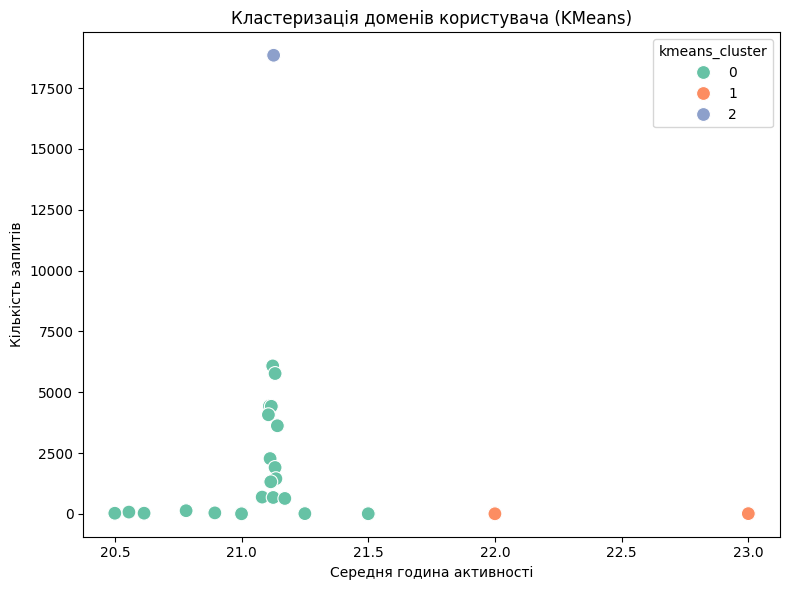

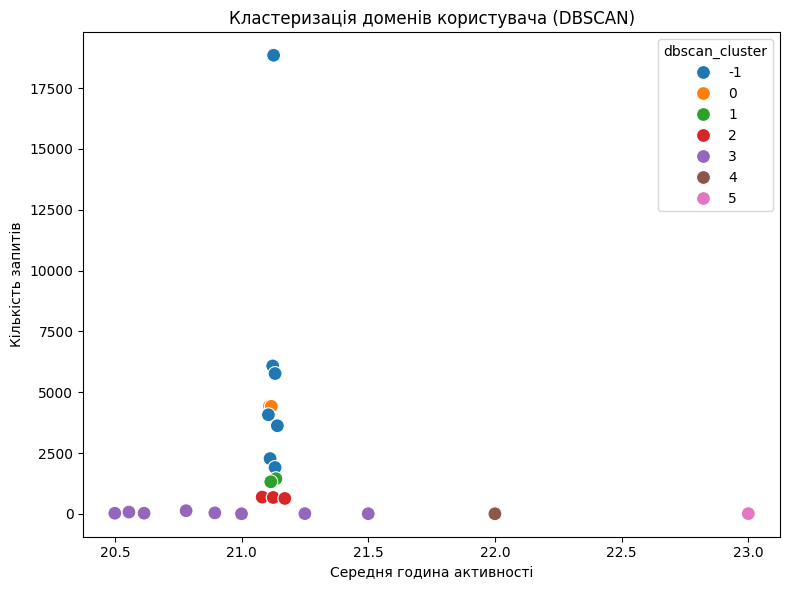

✅ Збережено кластеризований набір у clustered_domains.csv


In [5]:
#!/usr/bin/env python3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from datetime import datetime

df = pd.read_csv("aifw2/merged_logs.csv")

if "rrname" in df.columns and df["rrname"].notna().sum() > 0:
    df["domain"] = df["rrname"]
elif "hostname" in df.columns and df["hostname"].notna().sum() > 0:
    df["domain"] = df["hostname"]
elif "url" in df.columns and df["url"].notna().sum() > 0:
    df["domain"] = df["url"]
else:
    raise ValueError("Не знайдено жодної колонки з доменами (rrname / hostname / url)")

def extract_hour(ts):
    try:
        return pd.to_datetime(ts).hour
    except Exception:
        return None

if "timestamp" in df.columns:
    df["hour"] = df["timestamp"].apply(extract_hour)
elif "ts" in df.columns:
    df["hour"] = df["ts"].apply(extract_hour)
else:
    raise ValueError("Не знайдено колонки з часовими мітками (timestamp / ts)")

domain_stats = df["domain"].value_counts().reset_index()
domain_stats.columns = ["domain", "count"]

hourly_stats = df.groupby("domain")["hour"].mean().reset_index(name="mean_hour")

X = pd.merge(domain_stats, hourly_stats, on="domain", how="inner").dropna()
if len(X) < 3:
    raise ValueError("Недостатньо унікальних доменів для кластеризації!")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[["count", "mean_hour"]])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
X["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X["mean_hour"],
    y=X["count"],
    hue=X["kmeans_cluster"],
    palette="Set2",
    s=100
)
plt.title("Кластеризація доменів користувача (KMeans)")
plt.xlabel("Середня година активності")
plt.ylabel("Кількість запитів")
plt.tight_layout()
plt.show()

dbscan = DBSCAN(eps=0.8, min_samples=2)
X["dbscan_cluster"] = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X["mean_hour"],
    y=X["count"],
    hue=X["dbscan_cluster"],
    palette="tab10",
    s=100
)
plt.title("Кластеризація доменів користувача (DBSCAN)")
plt.xlabel("Середня година активності")
plt.ylabel("Кількість запитів")
plt.tight_layout()
plt.show()

X.to_csv("clustered_domains.csv", index=False)
print("✅ Збережено кластеризований набір у clustered_domains.csv")


In [6]:
import pandas as pd

df = pd.read_csv("clustered_domains.csv")

print("=== KMeans Clusters Summary ===")
kmeans_summary = df.groupby("kmeans_cluster")[["count", "mean_hour"]].agg(["mean", "std", "count"])
print(kmeans_summary)

print("\n=== DBSCAN Clusters Summary ===")
dbscan_summary = df.groupby("dbscan_cluster")[["count", "mean_hour"]].agg(["mean", "std", "count"])
print(dbscan_summary)


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
=== KMeans Clusters Summary ===
                       count                    mean_hour                
                        mean         std count       mean       std count
kmeans_cluster                                                           
0                   8.380776  160.174933  5951  21.003647  0.044137  5951
1                   2.063415    0.756496   820  22.002439  0.049356   820
2               18852.000000         NaN     1  21.126671       NaN     1

=== DBSCAN Clusters Summary ===
                      count                     mean_hour                
                       mean          std count       mean       std count
dbscan_cluster                                                           
-1              6081.142857  5848.715284     7  21.124958  0.012220     7
 0              4425.500000     7.778175     2  2

In [8]:
for cluster_id in sorted(df["kmeans_cluster"].unique()):
    print(f"\n=== KMeans Cluster {cluster_id} ===")
    cluster_domains = df[df["kmeans_cluster"] == cluster_id].sort_values("count", ascending=False)
    print(cluster_domains[["domain", "count", "mean_hour"]].head(10))



=== KMeans Cluster 0 ===
                 domain  count  mean_hour
1              pypi.org   6080  21.123026
2          www.iana.org   5768  21.132455
3           example.com   4431  21.110133
4     www.wikipedia.org   4420  21.117647
5    www.rfc-editor.org   4072  21.106090
6       docs.python.org   3620  21.141436
7       www.mozilla.org   2272  21.112676
8         picsum.photos   1904  21.132353
9   security.debian.org   1444  21.135734
10       deb.debian.org   1316  21.115502

=== KMeans Cluster 1 ===
                                         domain  count  mean_hour
20                                cdn.fwupd.org     16       22.0
21               metadata.ftp-master.debian.org     16       23.0
22   _https._tcp.metadata.ftp-master.debian.org      8       23.0
24                                   google.com      6       22.0
74                     client7689.sales.example      4       22.0
85                         finance25622.example      4       22.0
88                    cl

In [9]:
for cluster_id in sorted(df["dbscan_cluster"].unique()):
    print(f"\n=== DBSCAN Cluster {cluster_id} ===")
    cluster_domains = df[df["dbscan_cluster"] == cluster_id].sort_values("count", ascending=False)
    print(cluster_domains[["domain", "count", "mean_hour"]].head(10))



=== DBSCAN Cluster -1 ===
               domain  count  mean_hour
0         httpbin.org  18852  21.126671
1            pypi.org   6080  21.123026
2        www.iana.org   5768  21.132455
5  www.rfc-editor.org   4072  21.106090
6     docs.python.org   3620  21.141436
7     www.mozilla.org   2272  21.112676
8       picsum.photos   1904  21.132353

=== DBSCAN Cluster 0 ===
              domain  count  mean_hour
3        example.com   4431  21.110133
4  www.wikipedia.org   4420  21.117647

=== DBSCAN Cluster 1 ===
                 domain  count  mean_hour
9   security.debian.org   1444  21.135734
10       deb.debian.org   1316  21.115502

=== DBSCAN Cluster 2 ===
              domain  count  mean_hour
11        kernel.org    688  21.081395
12       git-scm.com    672  21.125000
13  speed.hetzner.de    632  21.170886

=== DBSCAN Cluster 3 ===
                                                domain  count  mean_hour
14                            debian.map.fastlydns.net    128  20.781250
15  

In [10]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

X = df[['count', 'mean_hour']].values
kmeans_labels = df['kmeans_cluster'].values
dbscan_labels = df['dbscan_cluster'].values

def safe_metrics(X, labels, name):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        print(f"{name}: недостатньо кластерів ({len(unique_labels)}).")
        return None, None, None
    
    try:
        sil = silhouette_score(X, labels)
    except:
        sil = np.nan
    
    try:
        dbi = davies_bouldin_score(X, labels)
    except:
        dbi = np.nan
    
    try:
        chi = calinski_harabasz_score(X, labels)
    except:
        chi = np.nan
    
    return sil, dbi, chi

sil_kmeans, dbi_kmeans, chi_kmeans = safe_metrics(X, kmeans_labels, "KMeans")
mask = dbscan_labels != -1
sil_dbscan, dbi_dbscan, chi_dbscan = safe_metrics(X[mask], dbscan_labels[mask], "DBSCAN")

print("=== 📊 KMeans ===")
print(f"Silhouette Score:       {sil_kmeans:.3f}")
print(f"Davies–Bouldin Index:   {dbi_kmeans:.3f}")
print(f"Calinski–Harabasz Index:{chi_kmeans:.3f}\n")

print("=== 🧠 DBSCAN ===")
print(f"Silhouette Score:       {sil_dbscan:.3f}")
print(f"Davies–Bouldin Index:   {dbi_dbscan:.3f}")
print(f"Calinski–Harabasz Index:{chi_dbscan:.3f}")

if sil_kmeans > sil_dbscan:
    print("\n🏆 За метрикою Silhouette кращий — KMeans.")
else:
    print("\n🏆 За метрикою Silhouette кращий — DBSCAN.")


=== 📊 KMeans ===
Silhouette Score:       -0.609
Davies–Bouldin Index:   1.326
Calinski–Harabasz Index:7872.686

=== 🧠 DBSCAN ===
Silhouette Score:       0.872
Davies–Bouldin Index:   0.251
Calinski–Harabasz Index:1738720.445

🏆 За метрикою Silhouette кращий — DBSCAN.
